<a href="https://colab.research.google.com/github/zizozozaziad1/Cats-Vs-Dogs/blob/main/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*In this notebook, we will focus on building a image classifier model that can extninguish between cats and dogs from images*





1- We will upload the dataset from kaggle and unzip it

In [11]:
! pip install kaggle


In [12]:
! mkdir ~/.kaggle


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [13]:
! cp kaggle.json ~/.kaggle/



In [14]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:36<00:00, 24.5MB/s]
100% 812M/812M [00:36<00:00, 23.4MB/s]


In [15]:
! unzip dogs-vs-cats.zip


Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [16]:
!unzip train.zip
!unzip test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

lets import the modules we will be using

In [27]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

This code is ued to get list of file names of both train and test folders

In [28]:
train_dir = '/content/train'
test_dir = '/content/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

This Python code defines a class named CatDogDataset that inherits from the Dataset class. This class is  used for loading and preprocessing a dataset of cat and dog images.  

the __len__ method is defined to return the number of files in the dataset. This is done by returning the length of self.file_list, which is a list of filenames that was passed to the class constructor when an instance was created.

 the __getitem__ method is used to load and preprocess an image from the dataset given its index.

In [44]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]



Data Augmentation:

In [45]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

This code segment is organizing and preparing a dataset for a binary classification task by filtering and separating image files into cat and dog categories and then concatenating these categories into a single dataset. This dataset can be used for training and evaluating a machine learning or deep learning model to classify images as either cats or dogs.

In [46]:
cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

Creating the dataloader so we later iterate over it in training/evaluation

In [47]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=4)


Visuallzing the first 24 images

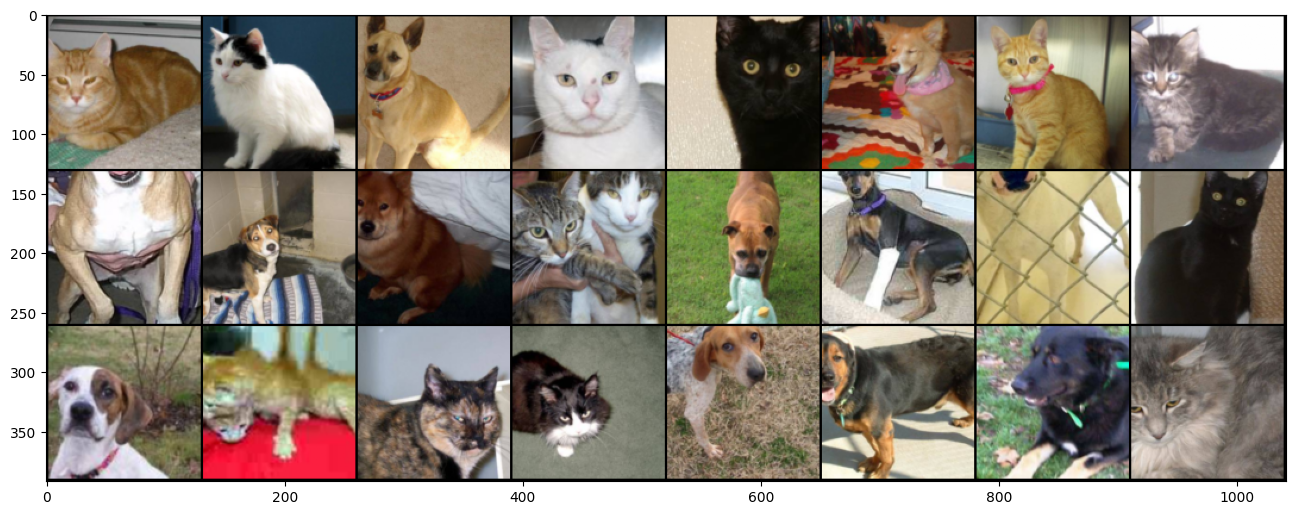

In [48]:
samples, labels = next(iter(dataloader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))


Transfer Learning

In [49]:


device = 'cuda'
model = torchvision.models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 70.3MB/s]


This code adapts a pre-trained DenseNet-121 model for a binary image classification task, sets up the loss function, optimizer, and a learning rate scheduler, and moves the model to the specified device(GPU) for training

In [50]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

This code trains the neural network model for a specified number of epochs, monitors and prints training progress at regular intervals, and records loss and accuracy values for later analysis

In [51]:
epochs = 3
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()

        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0

        itr += 1




[Epoch 1/3] Iteration 200 -> Train Loss: 0.4526, Accuracy: 0.719
[Epoch 1/3] Iteration 400 -> Train Loss: 0.3075, Accuracy: 0.875
[Epoch 1/3] Iteration 600 -> Train Loss: 0.2611, Accuracy: 0.875
[Epoch 2/3] Iteration 800 -> Train Loss: 0.1946, Accuracy: 0.906
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.1729, Accuracy: 0.938
[Epoch 2/3] Iteration 1200 -> Train Loss: 0.1464, Accuracy: 0.938
[Epoch 2/3] Iteration 1400 -> Train Loss: 0.1224, Accuracy: 1.000
[Epoch 3/3] Iteration 1600 -> Train Loss: 0.1347, Accuracy: 0.906
[Epoch 3/3] Iteration 1800 -> Train Loss: 0.1014, Accuracy: 1.000
[Epoch 3/3] Iteration 2000 -> Train Loss: 0.1058, Accuracy: 0.938
[Epoch 3/3] Iteration 2200 -> Train Loss: 0.0980, Accuracy: 0.969


This code saves the trained model's parameters to a file for later use and prepares a DataLoader for the test dataset, which can be used to evaluate the model's performance on unseen data.

In [52]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(model.state_dict(), filename_pth)

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

testset = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
testloader = DataLoader(testset, batch_size = 32, shuffle=False, num_workers=4)

This code  is responsible for evaluating a trained model on a test dataset and collecting the predictions

In [55]:
model.eval()
fn_list = []
pred_list = []
for x, fn in testloader:
    with torch.no_grad():
        x = x.to(device)
        output = model(x)
        pred = torch.argmax(output, dim=1)
        fn_list += [n[:-4] for n in fn]
        pred_list += [p.item() for p in pred]



This code is a visual display of 24 sample images, along with their predicted labels ('cat' or 'dog') as titles in a 4x6 grid format within the matplotlib figure

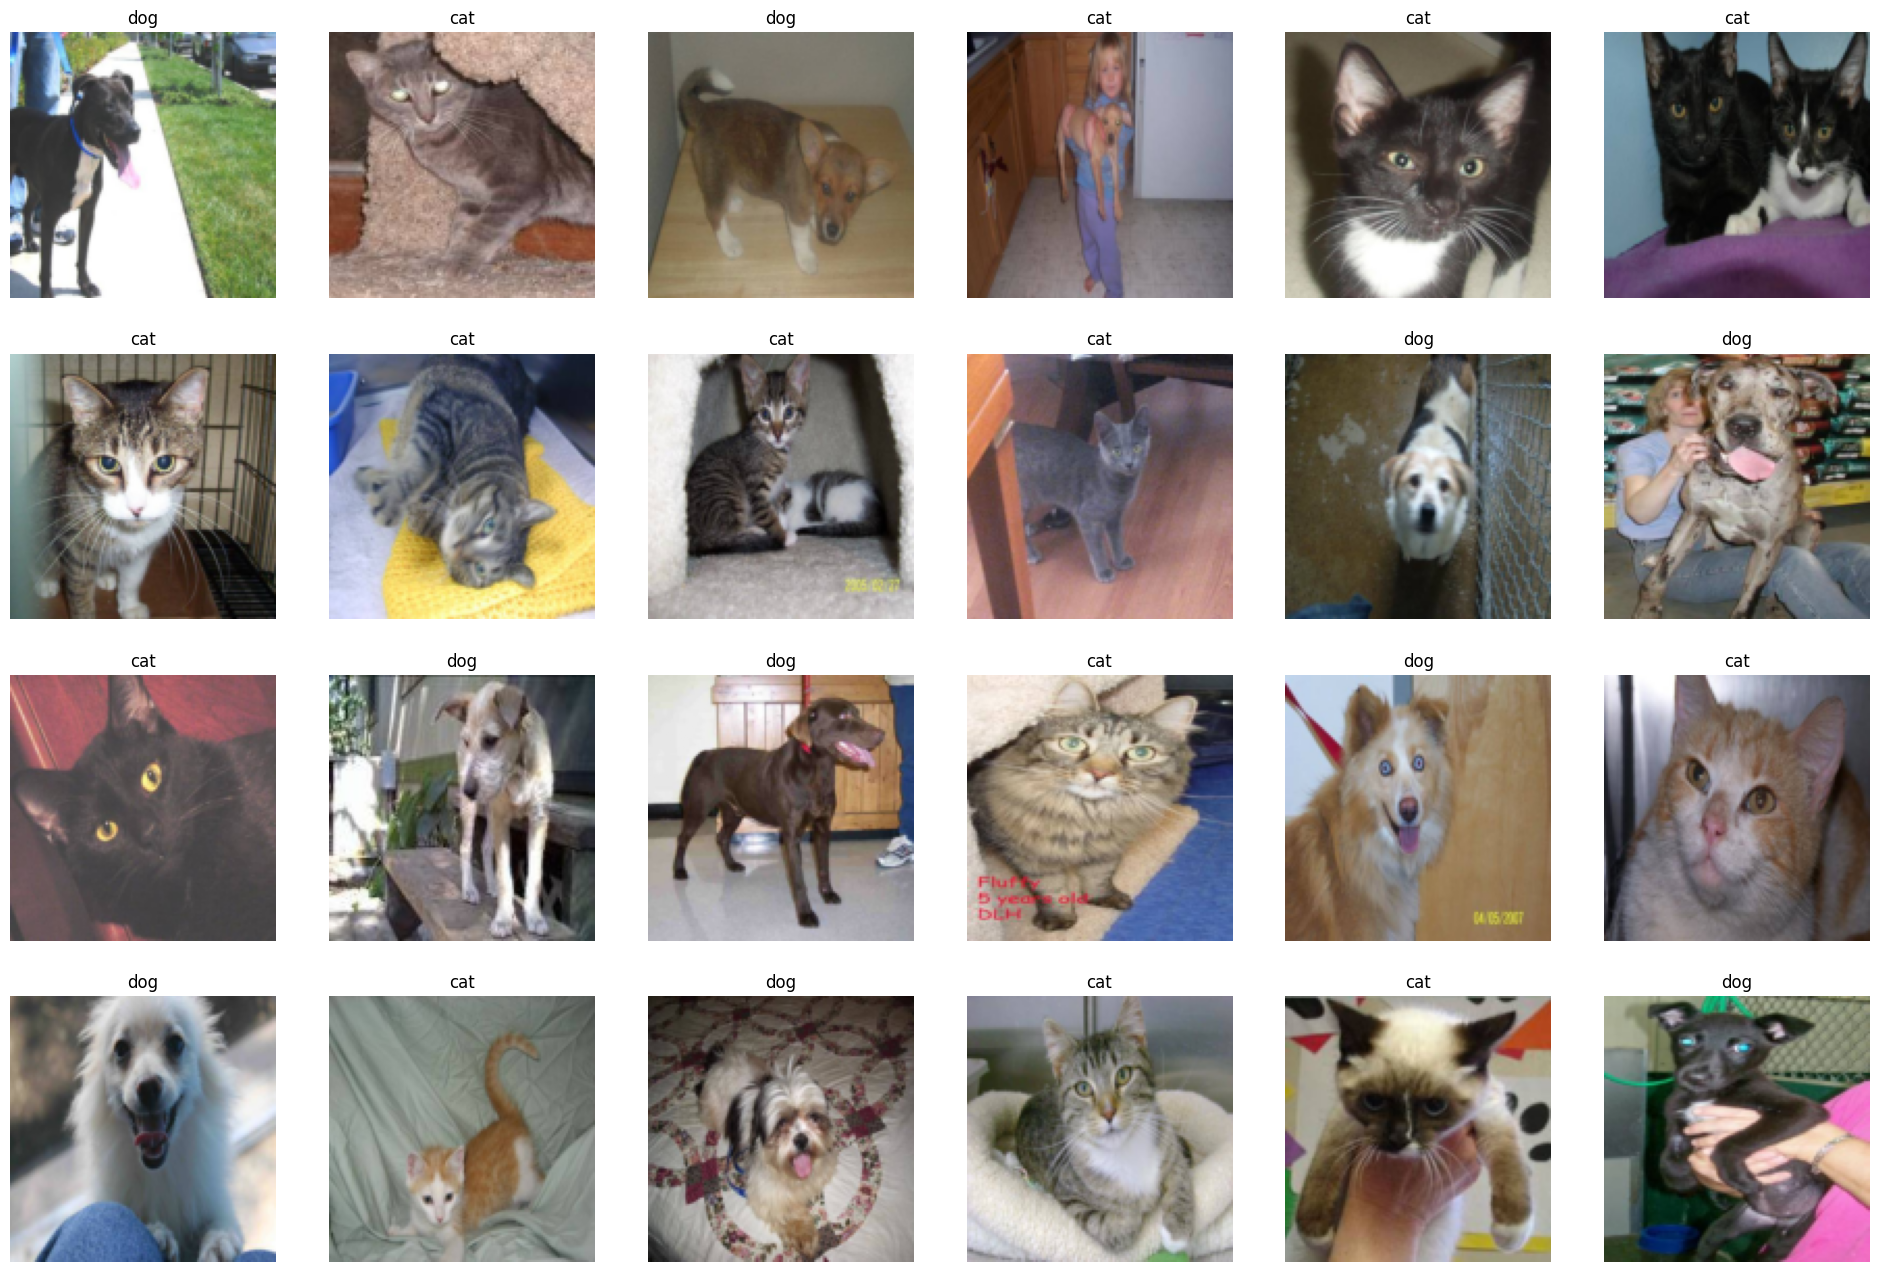

In [56]:
samples, _ = next(iter(testloader))
samples = samples.to(device)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))
